# Total carbon per country

- In this code we calculate the total carbon pero country with a csv as an output with the values classified in different years
- summary of the process:
  - get both rasters and vector data
  - adapt a table for the output
  - iterate over the rasters and iterate over the vector data
  - do the masking and sum the values of the output raster (array)
  - collect the results into a list
  - append the results to the adapted final table

In [17]:
import os
import geopandas as gpd
import rasterio
import rasterio.mask
from affine import Affine
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import platform
from rasterio.plot import show

In [13]:
"""This is the location of the raster files"""
# Note: the file name structure must be vcs_YYYY_global_300m.tif'
path = r"//akif.internal/public/veg_c_storage_rawdata"

"""Get a list of the raster files inside the folder"""
File_list = []
for file in os.listdir(path):
    # Iterate over all the files in the specified directory.
    if ".tif" in file:
        # Process the file if it has a .tif format.
        if platform.system() is "Windows":
            address = os.path.join(path, file).replace("/","\\")
        else:
            address = os.path.join(path, file).replace("\\","/")
            #build the path according the OS running the script
        if address not in File_list:
            # Add the file address to the list if it had not been added before.
            File_list.append(address)
    else:
        pass

File_list[0:1]

['\\\\akif.internal\\public\\veg_c_storage_rawdata\\vcs_2001_global_300m.tif']

In [14]:
"""This is the location of the vector global layer"""
globalmap = r"\\akif.internal\public\z_resources\im-wb\2015_gaul_dataset_mod_2015_gaul_dataset_gdba0000000b.shp"

if platform.system() is "Windows":
    globalmap = globalmap.replace("/","\\")
else:
    globalmap = globalmap.replace("\\","/")
    #build the path according the OS running the script

"""Prepare the dataframe / df for the final table"""   
gdf = gpd.read_file(globalmap)

df_final = pd.DataFrame(gdf.drop(columns='geometry'))
df_final = df_final.drop(["STATUS", "DISP_AREA", "ADM0_CODE", "STR0_YEAR", "EXP0_YEAR", "Shape_Leng", "ISO3166_1_", "ISO3166__1", "Shape_Le_1", "Shape_Area"], axis = 1)


In [15]:
def area_of_pixel(pixel_size, center_lat):

    a = 6378137  # meters
    b = 6356752.3142  # meters
    e = math.sqrt(1 - (b/a)**2)
    area_list = []
    for f in [center_lat+pixel_size/2, center_lat-pixel_size/2]:
        zm = 1 - e*math.sin(math.radians(f))
        zp = 1 + e*math.sin(math.radians(f))
        area_list.append(
            math.pi * b**2 * (
                math.log(zp/zm) / (2*e) +
                math.sin(math.radians(f)) / (zp*zm)))
    return (pixel_size / 360. * (area_list[0] - area_list[1])) * np.power(10.0,-4) 

In [12]:
def get_total_carbon_stock(out_image, out_transform, pixel_size, width_0, height_0, width_1, height_1):
    
    # Create matrix of coordinates based in tile number.
    cols, rows = np.meshgrid(np.arange(width_0, width_1), np.arange(height_0, height_1))

    # Transform the tile number coordinates to real coordinates and extract only latitude information. 
    ys = rasterio.transform.xy(out_transform, rows, cols)[1]
    latitudes = np.array(ys) # Cast the list of arrays to a 2D array for computational convenience.

    # Iterate over the latitudes matrix, calculate the area of each tile and store it in the real_raster_areas array.
    real_raster_areas = np.empty(np.shape(latitudes))
    for i, latitude_array in enumerate(latitudes):
        for j, latitude in enumerate(latitude_array):
            real_raster_areas[i,j] = area_of_pixel(pixel_size, latitude)

    # Calculate the total carbon stock in each tile: tonnes/hectare * hectares = tonnes.    
    total_carbon_stock_array = real_raster_areas * np.transpose(out_image[0,height_0:height_1,width_0:width_1])

    # Sum all the carbon stock values in the country treating NaNs as 0.0. 
    total_carbon_stock = np.nansum(total_carbon_stock_array) 

    return total_carbon_stock

In [33]:
def raster_tiling(out_image, out_transform, pixel_size, width, height):

    tilesize = 1000
    total_acumulated_carbon_stock = 0

    for i in range(tilesize, width, tilesize): #tilesize marks from where to where in width
        w0 = i
        w1 = min(i+tilesize, width) -i
        for j in range(tilesize, height, tilesize):
            #this is for the edge parts, so we don't get nodata from the borders
            h0 = j
            h1 = min(j+tilesize, height) - j

            total_carbon_stock = get_total_carbon_stock(out_image, out_transform, pixel_size, w0, h0, w1, h1)

            total_acumulated_carbon_stock += total_carbon_stock

    return total_acumulated_carbon_stock


In [16]:
"""We set ourselves in the folder with the rasters"""
os.chdir(path)

"""Iterate the rasters"""
for file in File_list[0:1]: # CUIDATO CUANDO TERMINES BORRALO
    """Take the year of the file"""
    file_start = file.find("vcs_") + 4
    file_end = file_start + 4
    file_year = str(file[file_start:file_end])
    print("We are working with the file {} from the year {}".format(file, file_year))


We are working with the file \\akif.internal\public\veg_c_storage_rawdata\vcs_2001_global_300m.tif from the year 2001


In [23]:

"""Create a list of the carbon values"""
carbon_values = []

"""Open the raster"""
with rasterio.open(file) as raster_file:

    gt = raster_file.transform # Get all the raster properties on a list.
    pixel_size = gt[0]

    """Iterate on the gdf"""
    for row_index, row in gdf.loc[233:233].iterrows(): # gdf.loc[0:1].iterrows():
        geo_row = gpd.GeoSeries(row['geometry'])

        print("\r", " working with the country {} ".format(row["ADM0_NAME"]))

        """Do the masking"""
        out_image, out_transform = rasterio.mask.mask(raster_file, geo_row, crop=True)
        print("the masking has been done")
        """get the pixel area value"""
        
        # Create a global raster where each pixel's value corresponds to its true area in hectares.

        # Obtain the number of tiles in both directions.
        height = out_image.shape[1]
        width  = out_image.shape[2]
        
        cols, rows = np.meshgrid(np.arange(width), np.arange(height))

        # Transform the tile number coordinates to real coordinates and extract only latitude information. 
        ys = rasterio.transform.xy(out_transform, rows, cols)[1]
        latitudes = np.array(ys) # Cast the list of arrays to a 2D array for computational convenience.

        # Iterate over the latitudes matrix, calculate the area of each tile and store it in the real_raster_areas array.
        real_raster_areas = np.empty(np.shape(latitudes))
        for i, latitude_array in enumerate(latitudes):
            for j, latitude in enumerate(latitude_array):
                real_raster_areas[i,j] = area_of_pixel(pixel_size, latitude)

        # Calculate the total carbon stock in each tile: tonnes/hectare * hectares = tonnes.    
        total_carbon_stock_array = real_raster_areas * out_image[0,0:height,0:width]

        # Sum all the carbon stock values in the country treating NaNs as 0.0. 
        total_carbon_stock = np.nansum(total_carbon_stock_array) 

        """Sum the values ignoring the nan values"""
        carbon_total = np.nansum(out_image) # nansum treats nan values as 0, we have to do this since with sum we get as result nan

        """Append the value to the list"""
        # carbon_values.append(total_carbon_stock)

        print("\r", "the country {} is finished".format(row["ADM0_NAME"]), end="") #this is, so we delete the previous print
        
print("\r", "Finished calculating {} year raster".format(file_year), end="")


"""Transform the list into a dataframe with the header of the year"""
# carbon_values_s = pd.DataFrame(carbon_values, columns = [file_year])

"""Append the dataframe to the final dataframe"""
# df_final = df_final.join(carbon_values_s)

"""Export the result"""
# df_final.to_csv("total_carbon.csv")

  working with the country Kiribati 
the masking has been done


KeyboardInterrupt: 

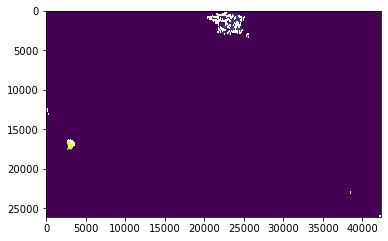

<AxesSubplot:>

In [20]:
show(out_image)

In [21]:
(out_image.nbytes) / np.power(10.0,9)

4.42091052

In [ ]:
height = out_image.shape[2]
width  = out_image.shape[1]

total_acumulated_carbon_stock = 0

if out_image.nbytes > (5* 10**9):
    print("the country  exceeds 5Gb of memory, we will split the array in tiles of 1000. Current size is GB: {} ".format(row["ADM0_NAME"], (out_image.nbytes) / np.power(10.0,9)))

    tilesize = 1000
    total_acumulated_carbon_stock = 0

    for i in range(0, width, tilesize): # [0:3] tilesize marks from where to where in width
        w0 = i #start of the array
        w_plus = min(i+tilesize, width) - i #addition value
        w1 = w0 + w_plus
        for j in range(0, height, tilesize):
            # [0:3] this is for the edge parts, so we don't get nodata from the borders
            h0 = j
            h_plus = min(j+tilesize, height) - j #addition value
            h1 = h0 + h_plus
            print("w0 ", w0, "w1 ", w1, "h0 ", h0, "h1 ", h1)
            cols, rows = np.meshgrid(np.arange(w0, w1), np.arange(h0, h1))

            # Transform the tile number coordinates to real coordinates and extract only latitude information. 
            ys = rasterio.transform.xy(out_transform, rows, cols)[1] # [0] is xs
            latitudes = np.array(ys) # Cast the list of arrays to a 2D array for computational convenience.

            # Iterate over the latitudes matrix, calculate the area of each tile and store it in the real_raster_areas array.
            real_raster_areas = np.empty(np.shape(latitudes))
            for i, latitude_array in enumerate(latitudes):
                for j, latitude in enumerate(latitude_array):
                    real_raster_areas[i,j] = area_of_pixel(pixel_size, latitude)

            # Calculate the total carbon stock in each tile: tonnes/hectare * hectares = tonnes.    
            total_carbon_stock_array = real_raster_areas * np.transpose(out_image[0,w0:w1,h0:h1])

            # Sum all the carbon stock values in the country treating NaNs as 0.0. 
            total_carbon_stock = np.nansum(total_carbon_stock_array) 
            
            total_acumulated_carbon_stock += total_carbon_stock
            # print(total_carbon_stock)
    print(total_acumulated_carbon_stock)

Here is the same code separated in different blocks for testing

In [5]:
"""This is the location of the raster files"""
# Note: the file name structure must be vcs_YYYY_global_300m.tif'
path = r"//akif.internal/public/veg_c_storage_rawdata"

"""Get a list of the raster files inside the folder"""
File_list = []
for file in os.listdir(path):
    # Iterate over all the files in the specified directory.
    if ".tif" in file:
        # Process the file if it has a .tif format.
        if platform.system() is "Windows":
            address = os.path.join(path, file).replace("/","\\")
        else:
            address = os.path.join(path, file).replace("\\","/")
            #build the path according the OS running the script
        if address not in File_list:
            # Add the file address to the list if it had not been added before.
            File_list.append(address)
    else:
        pass
print(File_list[0:2])

['\\\\akif.internal\\public\\veg_c_storage_rawdata\\vcs_2001_global_300m.tif', '\\\\akif.internal\\public\\veg_c_storage_rawdata\\vcs_2002_global_300m.tif']


In [6]:
"""We set ourselves in the folder with the rasters"""
os.chdir(path)

"""Iterate the rasters"""
for file in File_list[0:1]:
    """Take the year of the file"""
    file_start = file.find("vcs_") + 4
    file_end = file_start + 4
    file_year = str(file[file_start:file_end])
    print("We are working with the file {} from the year {}".format(file, file_year))

We are working with the file \\akif.internal\public\veg_c_storage_rawdata\vcs_2001_global_300m.tif from the year 2001


In [7]:
"""This is the location of the vector global layer"""
globalmap = r"\\akif.internal\public\z_resources\im-wb\2015_gaul_dataset_mod_2015_gaul_dataset_gdba0000000b.shp"

if platform.system() is "Windows":
    globalmap = globalmap.replace("/","\\")
else:
    globalmap = globalmap.replace("\\","/")
    #build the path according the OS running the script

"""Prepare the dataframe / df for the final table"""   
gdf = gpd.read_file(globalmap)

df_final = pd.DataFrame(gdf.drop(columns='geometry'))
df_final = df_final.drop(["STATUS", "DISP_AREA", "ADM0_CODE", "STR0_YEAR", "EXP0_YEAR", "Shape_Leng", "ISO3166_1_", "ISO3166__1", "Shape_Le_1", "Shape_Area"], axis = 1)


In [30]:
aggregated_carbon_stock_df = pd.DataFrame([])

carbon_values = []

"""Iterate on the gdf"""
for row_index, row in gdf.loc[87:87].iterrows(): # gdf.loc[0:1].iterrows():
    geo_row = gpd.GeoSeries(row['geometry'])

    """Do the masking"""
    with rasterio.open(file) as raster_file:
        
        
        
        # band = raster_file.read(1)
        out_image, out_transform = rasterio.mask.mask(raster_file, geo_row, crop=True)

        """get the pixel size"""

        
    """Sum the values ignoring the nan values"""
    carbon_total = np.nansum(out_image) # nansum treats nan values as 0, we have to do this since with sum we get as result nan

    """Append the value to the list"""
    carbon_values.append(carbon_total)

    print("the country {} is finished".format(row["ADM0_NAME"]))
    
print("Finished calculating {} Year".format(file_year))
# time: for 1 year took 83m

aggregated_carbon_stock = pd.DataFrame(carbon_values, columns = [file_year]) 

# # Join this year's carbon stocks to the final, multi-year DataFrame.
# aggregated_carbon_stock_df = pd.merge(aggregated_carbon_stock_df, aggregated_carbon_stock, how='outer', left_index = True, right_index=True)

the country Rwanda is finished
Finished calculating 2001 Year


In [18]:
import math 
def area_of_pixel(pixel_size, center_lat):
    """Calculate m^2 area of a wgs84 square pixel.

    Adapted from: https://gis.stackexchange.com/a/127327/2397

    Parameters:
        pixel_size (float): length of side of pixel in degrees.
        center_lat (float): latitude of the center of the pixel. Note this
            value +/- half the `pixel-size` must not exceed 90/-90 degrees
            latitude or an invalid area will be calculated.

    Returns:
        Area of square pixel of side length `pixel_size` centered at
        `center_lat` in m^2.

    """
    a = 6378137  # meters
    b = 6356752.3142  # meters
    e = math.sqrt(1 - (b/a)**2)
    area_list = []
    for f in [center_lat+pixel_size/2, center_lat-pixel_size/2]:
        zm = 1 - e*math.sin(math.radians(f))
        zp = 1 + e*math.sin(math.radians(f))
        area_list.append(
            math.pi * b**2 * (
                math.log(zp/zm) / (2*e) +
                math.sin(math.radians(f)) / (zp*zm)))
    return pixel_size / 360. * (area_list[0] - area_list[1])

In [34]:
"""Check if the result is correct"""
print(np.unique(out_image))
count_5 = np.count_nonzero(out_image == 5)
count_1 = np.count_nonzero(out_image == 1)
print(count_5, count_1)

[ 0.  1.  5. nan]
11422 7


In [50]:
"""Transform the list into a dataframe with the header of the year"""
carbon_values_s = pd.DataFrame(carbon_values, columns = [file_year])


In [51]:
"""Append the dataframe to the final dataframe"""
df_final_copy = df_final.join(carbon_values_s)

In [53]:
"""Export the result"""
df_final_copy.to_csv("total_carbon.csv")

In [31]:
"""This is the output method for rasterio
the code expects 2 dimensions (height and width), so we 
have to transform the array from 3 to two dimensions like this [0,:,:]
"""

"""Prepare the metadata for the output"""
# out_band = raster_file.read(1)
# out_meta = out_image.meta
# out_meta.update(
#         dtype=rasterio.float32,
#         count=1,
#         compress='deflate')

out_image_2 = out_image[0,:,:]

"""testing write result"""
with rasterio.open(os.path.join(path, 'Rwanda_carbon_2001.tif').replace("/","\\"), 'w', driver='GTiff', height = out_image_2.shape[0], width = out_image_2.shape[1],
                            count=1, dtype=str(out_image_2.dtype),
                            crs= rasterio.crs.CRS.from_string("EPSG:4326"),
                            transform=out_transform, compress='deflate') as dst:
    dst.write_band(1, out_image[0,:,:].astype(rasterio.float32))